In [1]:
import os
import json

import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# Global Wheat Detection Dataset EDA

## Download Dataset

In [2]:
!pip install aicrowd-cli

In [3]:
API_KEY = "" 
!aicrowd login --api-key $API_KEY

Error: --api-key option requires an argument


In [4]:
!aicrowd dataset download --challenge global-wheat-challenge-2021

CLI Error: Config property aicrowd_api_key not set
Please run aicrowd login to login.


In [5]:
!mkdir -p ../data/gwhd

In [6]:
!unzip train.zip -d ../data/gwhd
!rm train.zip

unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.
rm: cannot remove 'train.zip': No such file or directory


In [7]:
!unzip test.zip -d ../data/gwhd
!rm test.zip

unzip:  cannot find or open test.zip, test.zip.zip or test.zip.ZIP.
rm: cannot remove 'test.zip': No such file or directory


## General Dataset Information

**Load dataset**

In [8]:
DATA_ROOT = 'gwhd_2021'

In [9]:
data = pd.read_csv(os.path.join(DATA_ROOT, 'competition_train.csv'))
data.tail()

image_name  \
3652  aa8967fdf620ab4d7b6ff75531ad37cf16a5f5deca131d...   
3653  4bfbbdac0fd5c16db471aa3dcfa20e6b2bbd60230b1969...   
3654  cd4a7c09f3b6832278f24d30b9143718dfde8998f2da78...   
3655  3362115207dbd2b1e28cb22b14eb910a0cb1068c7e47b7...   
3656  de85de89b3969fc6eb97d0c83299ad725a52595bde4533...   

                                            BoxesString          domain  
3652  53 81 175 142;0 0 100 129;0 0 42 77;144 0 250 ...  ULiège-GxABT_1  
3653  5 0 62 85;46 0 92 24;82 9 159 146;48 74 301 20...  ULiège-GxABT_1  
3654  200 105 345 358;144 128 280 316;276 0 360 108;...  ULiège-GxABT_1  
3655  0 0 214 84;0 114 57 170;0 322 24 367;56 382 16...  ULiège-GxABT_1  
3656  98 0 158 41;0 0 42 49;0 78 26 143;324 86 374 1...  ULiège-GxABT_1

**Decode `BoxesString`**

In [10]:
def decodeString(BoxesString):
      """
      Small method to decode the BoxesString
      """
      if BoxesString == "no_box":
          return np.zeros((0,4))
      else:
          try:
              boxes =  np.array([np.array([int(i) for i in box.split(" ")])
                              for box in BoxesString.split(";")])
              return boxes
          except:
              print(BoxesString)
              print("Submission is not well formatted. empty boxes will be returned")
              return np.zeros((0,4))

In [11]:
boxes = [decodeString(item) for item in data["BoxesString"]]
data["boxes"] = boxes
data.tail()

image_name  \
3652  aa8967fdf620ab4d7b6ff75531ad37cf16a5f5deca131d...   
3653  4bfbbdac0fd5c16db471aa3dcfa20e6b2bbd60230b1969...   
3654  cd4a7c09f3b6832278f24d30b9143718dfde8998f2da78...   
3655  3362115207dbd2b1e28cb22b14eb910a0cb1068c7e47b7...   
3656  de85de89b3969fc6eb97d0c83299ad725a52595bde4533...   

                                            BoxesString          domain  \
3652  53 81 175 142;0 0 100 129;0 0 42 77;144 0 250 ...  ULiège-GxABT_1   
3653  5 0 62 85;46 0 92 24;82 9 159 146;48 74 301 20...  ULiège-GxABT_1   
3654  200 105 345 358;144 128 280 316;276 0 360 108;...  ULiège-GxABT_1   
3655  0 0 214 84;0 114 57 170;0 322 24 367;56 382 16...  ULiège-GxABT_1   
3656  98 0 158 41;0 0 42 49;0 78 26 143;324 86 374 1...  ULiège-GxABT_1   

                                                  boxes  
3652  [[53, 81, 175, 142], [0, 0, 100, 129], [0, 0, ...  
3653  [[5, 0, 62, 85], [46, 0, 92, 24], [82, 9, 159,...  
3654  [[200, 105, 345, 358], [144, 128, 280, 316], [...  
3655  [[0, 0, 214, 84], [0, 114, 57, 170], [0, 322, ...  
3656  [[98, 0, 158, 41], [0, 0, 42, 49], [0, 78, 26,...

### Basic data stats

**Count the number of images in the train set**

In [12]:
print('There are {} images in the train set'.format(len(data)))


There are 3657 images in the train set


**Compute the average number of labeled wheat heads (bounding boxes) per image**

In [13]:
box_count = sum([len(listElem) for listElem in boxes])

In [14]:

print('On average, there are {} boxes per image'.format(round(box_count / len(data), 2)))



On average, there are 44.76 boxes per image


**Count the number of images without bounding boxes**

In [15]:
no_boxes = data.loc[data['BoxesString'] == 'no_box']

In [16]:
print('There are {} images without wheat heads.'.format(len(no_boxes)))

There are 50 images without wheat heads.


**Count the number of bounding boxes per image**

In [17]:
counts = []

for index in tqdm(range(len(data))):
  row = data.iloc[index]
  img_name = row.image_name
  count = len(row.boxes)

  counts.append([img_name, count])

boxes_per_image = pd.DataFrame(counts, columns=["image_id", "count"])

ipykernel_launcher:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3657 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

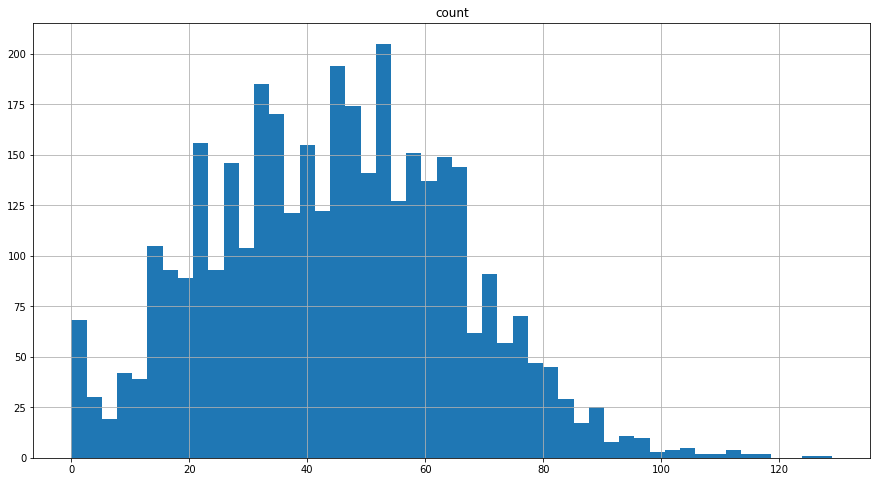

In [18]:
boxes_per_image.hist(bins=50, figsize=(15, 8))

**Get the distribution of bounding box sizes**

In [19]:
# compute area of bounding boxes

def compute_area(bbox):
    box_w = bbox[2] - bbox[0]
    box_h = bbox[3] - bbox[1]
    return box_w * box_h

box_areas = []
for listElem in boxes:
    box_areas.append([compute_area(bbox) for bbox in listElem])

data['box_areas'] = box_areas
data.tail()

image_name  \
3652  aa8967fdf620ab4d7b6ff75531ad37cf16a5f5deca131d...   
3653  4bfbbdac0fd5c16db471aa3dcfa20e6b2bbd60230b1969...   
3654  cd4a7c09f3b6832278f24d30b9143718dfde8998f2da78...   
3655  3362115207dbd2b1e28cb22b14eb910a0cb1068c7e47b7...   
3656  de85de89b3969fc6eb97d0c83299ad725a52595bde4533...   

                                            BoxesString          domain  \
3652  53 81 175 142;0 0 100 129;0 0 42 77;144 0 250 ...  ULiège-GxABT_1   
3653  5 0 62 85;46 0 92 24;82 9 159 146;48 74 301 20...  ULiège-GxABT_1   
3654  200 105 345 358;144 128 280 316;276 0 360 108;...  ULiège-GxABT_1   
3655  0 0 214 84;0 114 57 170;0 322 24 367;56 382 16...  ULiège-GxABT_1   
3656  98 0 158 41;0 0 42 49;0 78 26 143;324 86 374 1...  ULiège-GxABT_1   

                                                  boxes  \
3652  [[53, 81, 175, 142], [0, 0, 100, 129], [0, 0, ...   
3653  [[5, 0, 62, 85], [46, 0, 92, 24], [82, 9, 159,...   
3654  [[200, 105, 345, 358], [144, 128, 280, 316], [...   
3655  [[0, 0, 214, 84], [0, 114, 57, 170], [0, 322, ...   
3656  [[98, 0, 158, 41], [0, 0, 42, 49], [0, 78, 26,...   

                                              box_areas  
3652  [7442, 12900, 3234, 15476, 5694, 24800, 7502, ...  
3653  [4845, 1104, 10549, 32384, 17340, 17170, 4453,...  
3654  [36685, 25568, 9072, 16929, 25773, 15210, 1849...  
3655  [17976, 3192, 1080, 13936, 6968, 6072, 6996, 1...  
3656  [2460, 2058, 1690, 3600, 24684, 8502, 4500, 16...

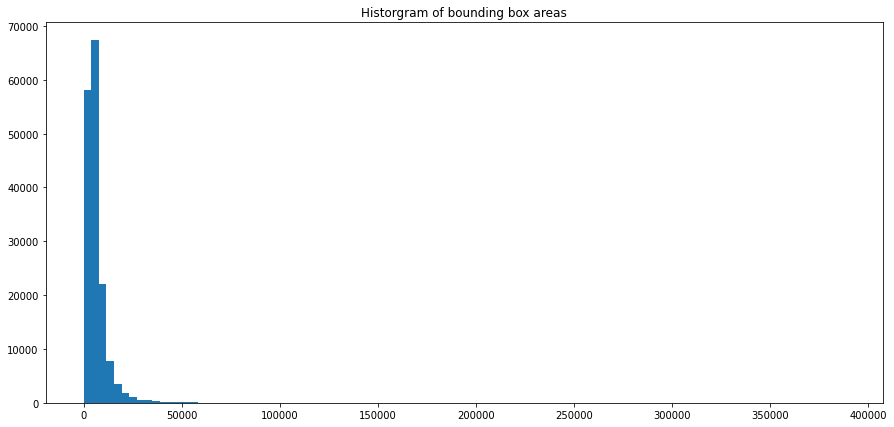

In [20]:
bbox_areas = np.array([elem for sub_list in box_areas for elem in sub_list])

plt.figure(figsize=(15, 7))
plt.hist(bbox_areas, bins=100)
plt.title('Historgram of bounding box areas')
plt.show()

In [21]:
box_area_df = pd.DataFrame(bbox_areas)
box_area_df.describe()

0
count  163690.000000
mean     6377.742654
std      5939.688626
min        24.000000
25%      3198.000000
50%      4914.000000
75%      7524.000000
max    387960.000000

### Data Visualization

In [22]:
# helper functions
def get_all_bboxes(data, image_id):
    '''
    Get all bouding boxes for a given image_id
    '''
    bboxes = data.loc[data['image_name'] == image_id].boxes.values[0]
    return bboxes

def plot_image_examples(data, rows=3, cols=3, title='Image examples', root=DATA_ROOT):
    fig, axs = plt.subplots(rows, cols, figsize=(20, 12))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(data), size=1)[0]
            img_id = data.iloc[idx].image_name
            
            img = cv2.imread(os.path.join(root, 'images', img_id))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            bboxes = get_all_bboxes(data, img_id)
            
            # draw the bounding boxes
            for bbox in bboxes:
                cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 5)
              
            axs[row, col].imshow(img)
            axs[row, col].axis('off')
            axs[row, col].set_aspect('equal')
    plt.suptitle(title)
    plt.tight_layout()

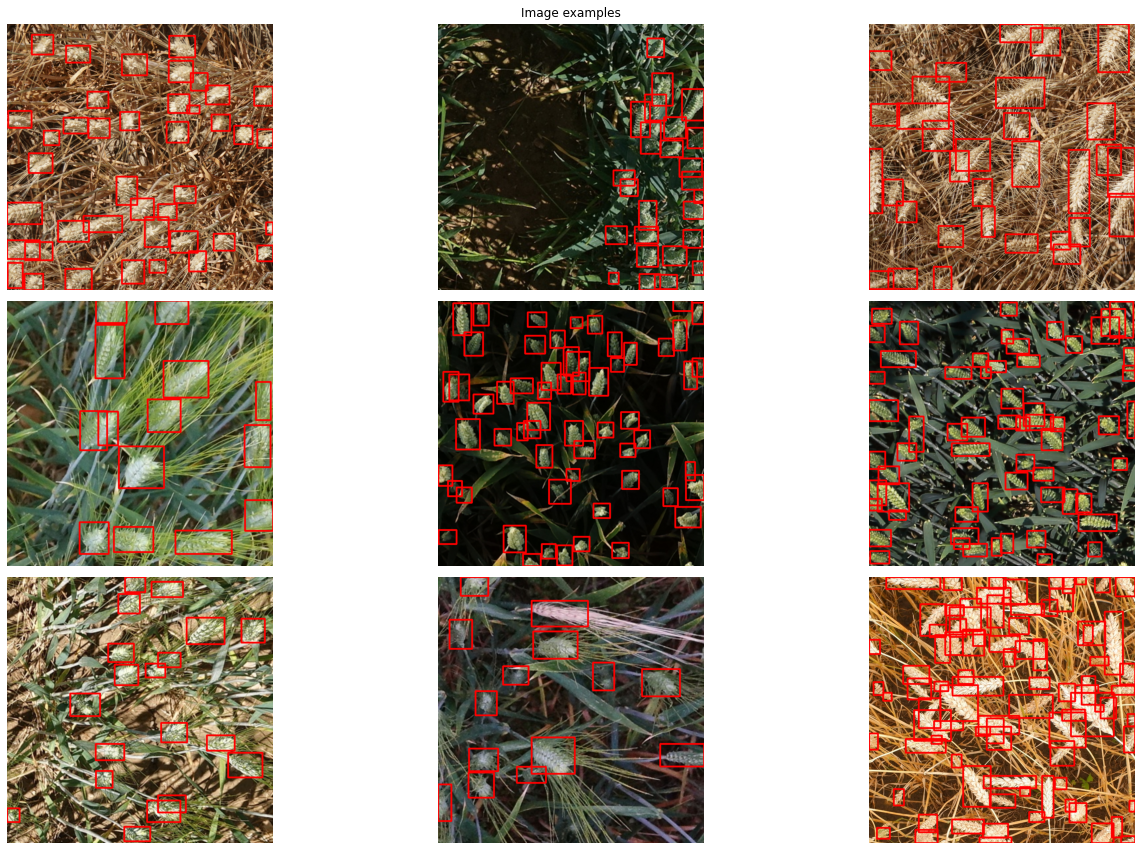

In [23]:
plot_image_examples(data)

**Plot some images with fewer bounding boxes than average**

In [24]:
data['box_count'] = boxes_per_image['count'].to_list()
data.tail()

image_name  \
3652  aa8967fdf620ab4d7b6ff75531ad37cf16a5f5deca131d...   
3653  4bfbbdac0fd5c16db471aa3dcfa20e6b2bbd60230b1969...   
3654  cd4a7c09f3b6832278f24d30b9143718dfde8998f2da78...   
3655  3362115207dbd2b1e28cb22b14eb910a0cb1068c7e47b7...   
3656  de85de89b3969fc6eb97d0c83299ad725a52595bde4533...   

                                            BoxesString          domain  \
3652  53 81 175 142;0 0 100 129;0 0 42 77;144 0 250 ...  ULiège-GxABT_1   
3653  5 0 62 85;46 0 92 24;82 9 159 146;48 74 301 20...  ULiège-GxABT_1   
3654  200 105 345 358;144 128 280 316;276 0 360 108;...  ULiège-GxABT_1   
3655  0 0 214 84;0 114 57 170;0 322 24 367;56 382 16...  ULiège-GxABT_1   
3656  98 0 158 41;0 0 42 49;0 78 26 143;324 86 374 1...  ULiège-GxABT_1   

                                                  boxes  \
3652  [[53, 81, 175, 142], [0, 0, 100, 129], [0, 0, ...   
3653  [[5, 0, 62, 85], [46, 0, 92, 24], [82, 9, 159,...   
3654  [[200, 105, 345, 358], [144, 128, 280, 316], [...   
3655  [[0, 0, 214, 84], [0, 114, 57, 170], [0, 322, ...   
3656  [[98, 0, 158, 41], [0, 0, 42, 49], [0, 78, 26,...   

                                              box_areas  box_count  
3652  [7442, 12900, 3234, 15476, 5694, 24800, 7502, ...         59  
3653  [4845, 1104, 10549, 32384, 17340, 17170, 4453,...         59  
3654  [36685, 25568, 9072, 16929, 25773, 15210, 1849...         51  
3655  [17976, 3192, 1080, 13936, 6968, 6072, 6996, 1...         75  
3656  [2460, 2058, 1690, 3600, 24684, 8502, 4500, 16...         56

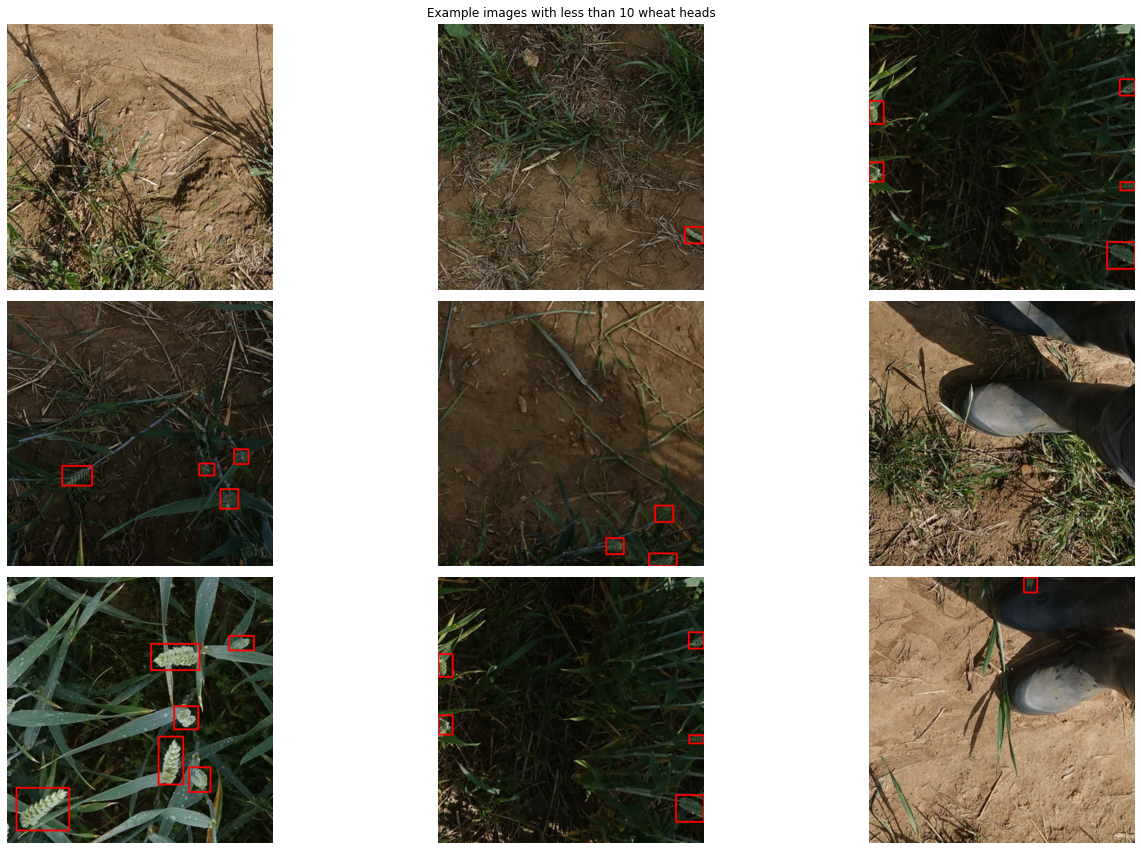

In [25]:
imgs_with_fewer_boxes = data.loc[data['box_count'] < 10]
plot_image_examples(imgs_with_fewer_boxes, title='Example images with less than 10 wheat heads')

**Plot some images with more bounding boxes than average**

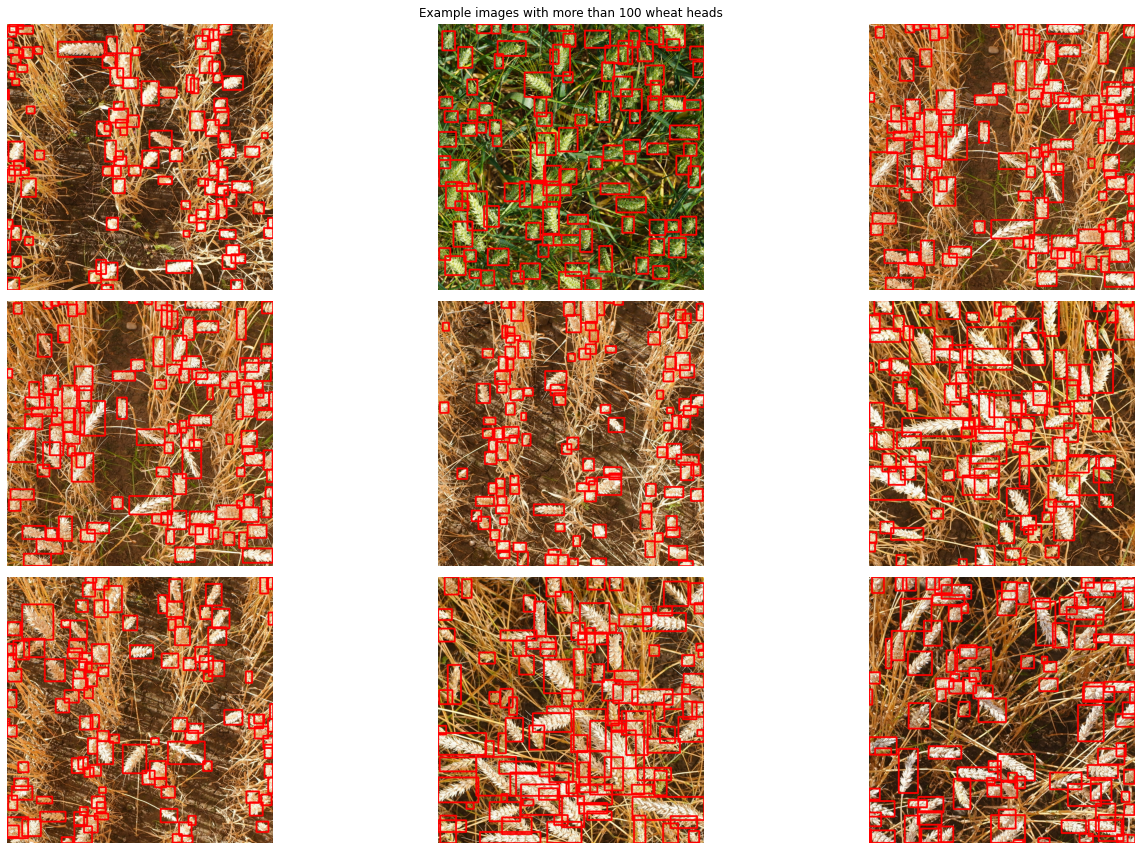

In [26]:
imgs_with_more_boxes = data.loc[data['box_count'] > 100]
plot_image_examples(imgs_with_more_boxes, title='Example images with more than 100 wheat heads')

## Convert annotations to COCO format

In [27]:
ANNOTATIONS_DIR = os.path.join(DATA_ROOT, 'annotations')
if not os.path.exists(ANNOTATIONS_DIR):
    os.makedirs(ANNOTATIONS_DIR)

In [28]:
# load csv files
train_dataset = pd.read_csv(os.path.join(DATA_ROOT, 'competition_train.csv'))
val_dataset = pd.read_csv(os.path.join(DATA_ROOT, 'competition_val.csv'))
test_dataset = pd.read_csv(os.path.join(DATA_ROOT, 'competition_test.csv'))

combined_test_set = val_dataset.append(test_dataset, ignore_index=True)

# write combined test set to disk
combined_test_set.to_csv(os.path.join(DATA_ROOT, "combined_test_set.csv"), index=False)


In [29]:
def xyxy2xywh(boxes):
  y = np.copy(boxes)
  y[:, 2] = boxes[:, 2] - boxes[:, 0]  # width
  y[:, 3] = boxes[:, 3] - boxes[:, 1]  # height
  return y

def convert_to_coco(df, root_dir):
  df["domain_id"] = df.domain.astype("category").cat.codes # convert domain str to categorical
  ann = {
    'images': [],
    'annotations': [],
    'categories': [{"id": 0, "name": "wheat_head", "supercategory": None}]
  }
  ann_count = 0

  for idx, row in enumerate(df.itertuples(index=False)):
    img = cv2.imread(os.path.join(root_dir, 'images', row.image_name))
    width = img.shape[1]
    height = img.shape[0]

    ann['images'].append({
      'id': idx,
      'width': width,
      'height': height,
      'file_name': row.image_name,
      'domain': row.domain,
      'domain_id': row.domain_id   # used for the ADA metric
    })

    boxes_string = row.BoxesString
    bboxes = decodeString(boxes_string)
    coco_bboxes = xyxy2xywh(bboxes)

    for box in coco_bboxes:
      ann['annotations'].append({
        "id": ann_count,
        "image_id": idx,
        "category_id": 0,
        "segmentation": None,
        "area": float(box[2] * box[3]),
        "bbox": box.tolist(),
        "iscrowd": 0,
      })
      ann_count += 1

  return ann

In [30]:
train_ann = convert_to_coco(train_dataset, DATA_ROOT)
test_ann = convert_to_coco(combined_test_set, DATA_ROOT)

with open(os.path.join(ANNOTATIONS_DIR, 'train.json'), 'w') as f:
    json.dump(train_ann, f)

with open(os.path.join(ANNOTATIONS_DIR, 'test.json'), 'w') as f:
    json.dump(test_ann, f)
print('Done!')